Part 1

In [12]:
import cv2
import matplotlib.pyplot as plt

def cartoonify_images(image_paths):
    for image_path in image_paths:

        image = cv2.imread(image_path)
            
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        small_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

        for _ in range(5):  
            small_image = cv2.bilateralFilter(small_image, d=9, sigmaColor=75, sigmaSpace=75)

        bilateral_filtered_image = cv2.resize(small_image, (image.shape[1], image.shape[0]))
        bilateral_filtered_image_rgb = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2RGB)

        smoothed_image = cv2.medianBlur(gray_image, 7)   # 7 is the kernel size
        laplacian_edges = cv2.Laplacian(smoothed_image, cv2.CV_8U, ksize=5) # if ksize is large edges will be thicker but less sensitive  
        _, edge_mask = cv2.threshold(laplacian_edges, 100, 255, cv2.THRESH_BINARY_INV) # binary image , value > 100(threshold) map to 0 (black) otherwise 255 (white)

        edge_mask_colored = cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2BGR)

        cartoon_image = cv2.bitwise_and(bilateral_filtered_image, edge_mask_colored)
        cartoon_image_rgb = cv2.cvtColor(cartoon_image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(15, 15))

        # Original Grayscale vs Smoothed Grayscale
        plt.subplot(5, 2, 1)
        plt.imshow(gray_image, cmap='gray')
        plt.title("Original Grayscale")
        plt.axis("off")

        plt.subplot(5, 2, 2)
        plt.imshow(smoothed_image, cmap='gray')
        plt.title("Smoothed Grayscale")
        plt.axis("off")

        # Smoothed Grayscale vs Edge Detection Output
        plt.subplot(5, 2, 3)
        plt.imshow(smoothed_image, cmap='gray')
        plt.title("Smoothed Grayscale")
        plt.axis("off")

        plt.subplot(5, 2, 4)
        plt.imshow(laplacian_edges, cmap='gray')
        plt.title("Edge Detection Output")
        plt.axis("off")

        # Edge Detection Output vs Output After Image Thresholding
        plt.subplot(5, 2, 5)
        plt.imshow(laplacian_edges, cmap='gray')
        plt.title("Edge Detection Output")
        plt.axis("off")

        plt.subplot(5, 2, 6)
        plt.imshow(edge_mask, cmap='gray')
        plt.title("Output After Thresholding")
        plt.axis("off")

        # Original Image vs Output from Bilateral Filter
        plt.subplot(5, 2, 7)
        plt.imshow(image_rgb)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(5, 2, 8)
        plt.imshow(bilateral_filtered_image_rgb)
        plt.title("Output from Bilateral Filter")
        plt.axis("off")

        # Output from Bilateral Filter vs Final Output
        plt.subplot(5, 2, 9)
        plt.imshow(bilateral_filtered_image_rgb)
        plt.title("Output from Bilateral Filter")
        plt.axis("off")

        plt.subplot(5, 2, 10)
        plt.imshow(cartoon_image_rgb)
        plt.title("Final Output (Cartoonified Image)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


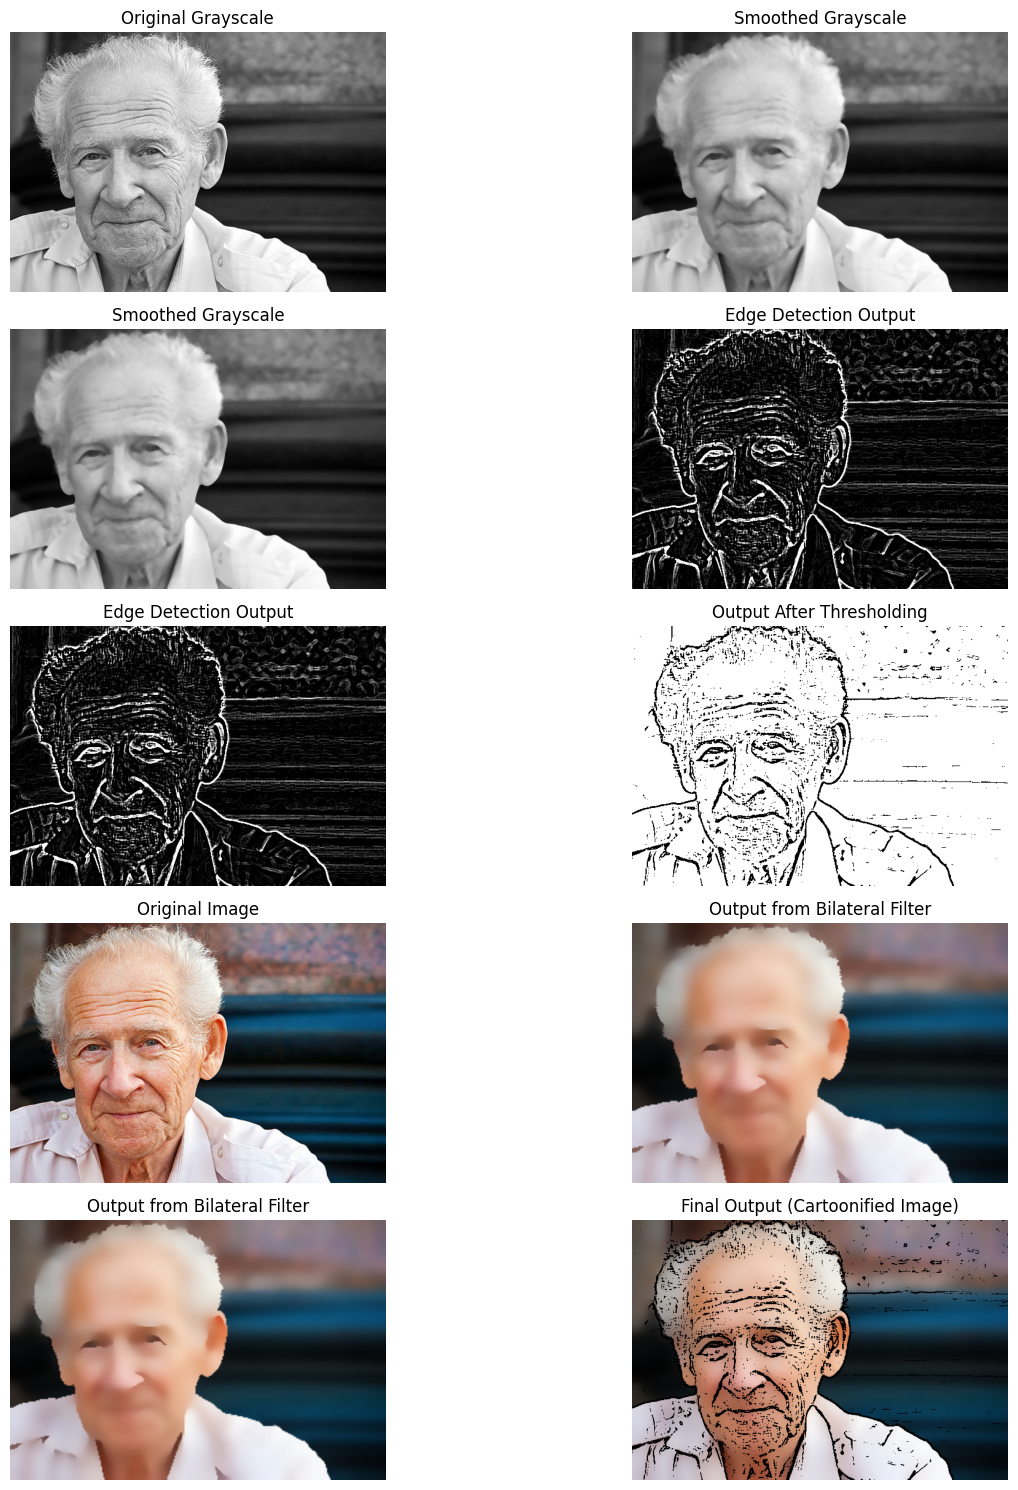

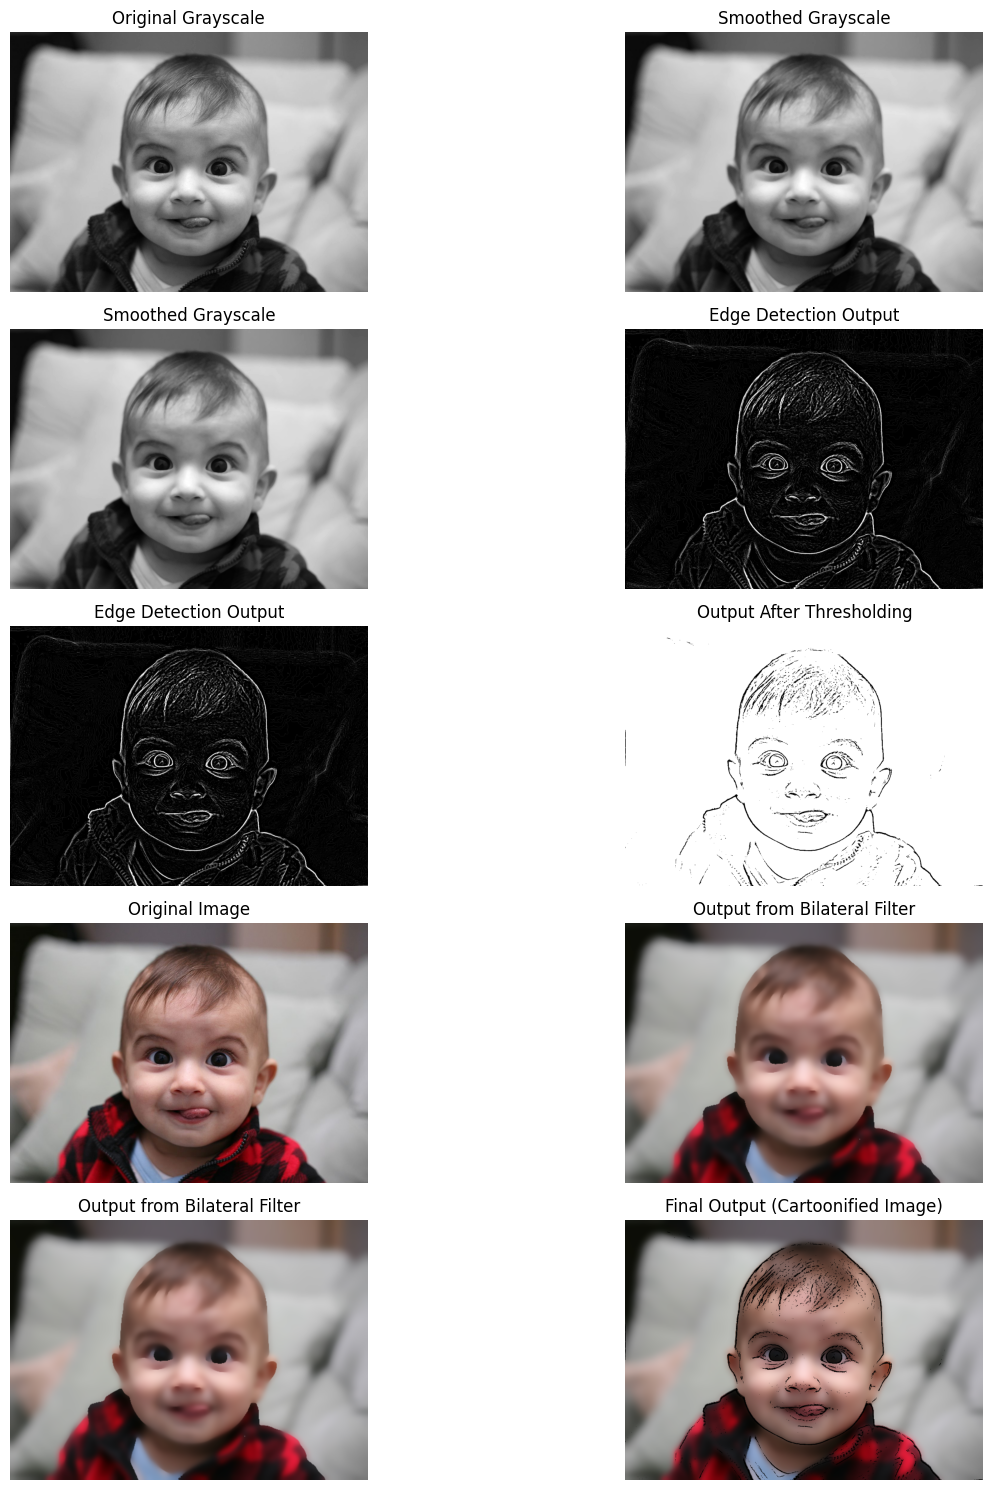

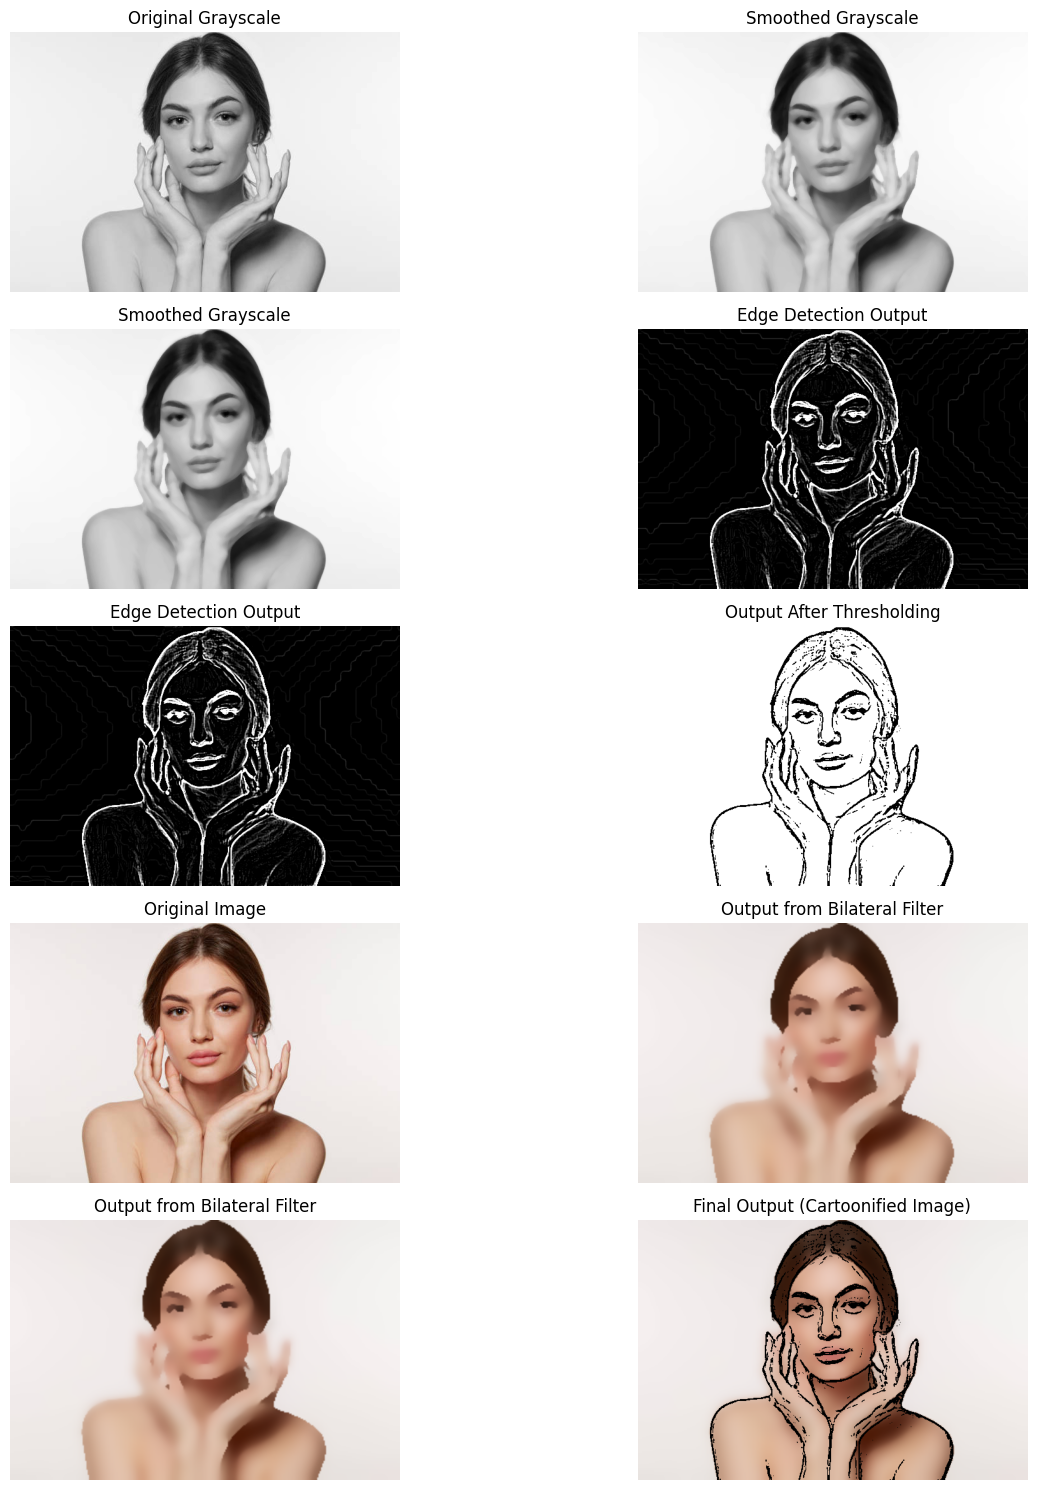

In [ ]:
image_paths = [
    r"C:\Users\nabee\OneDrive\Desktop\CV\istockphoto-153011771-612x612.jpg",
    r"C:\Users\nabee\OneDrive\Desktop\CV\Baby_Face.JPG",  
    r"C:\Users\nabee\OneDrive\Desktop\CV\istockphoto-1442556244-612x612.jpg"
]
cartoonify_images(image_paths)


Part 2

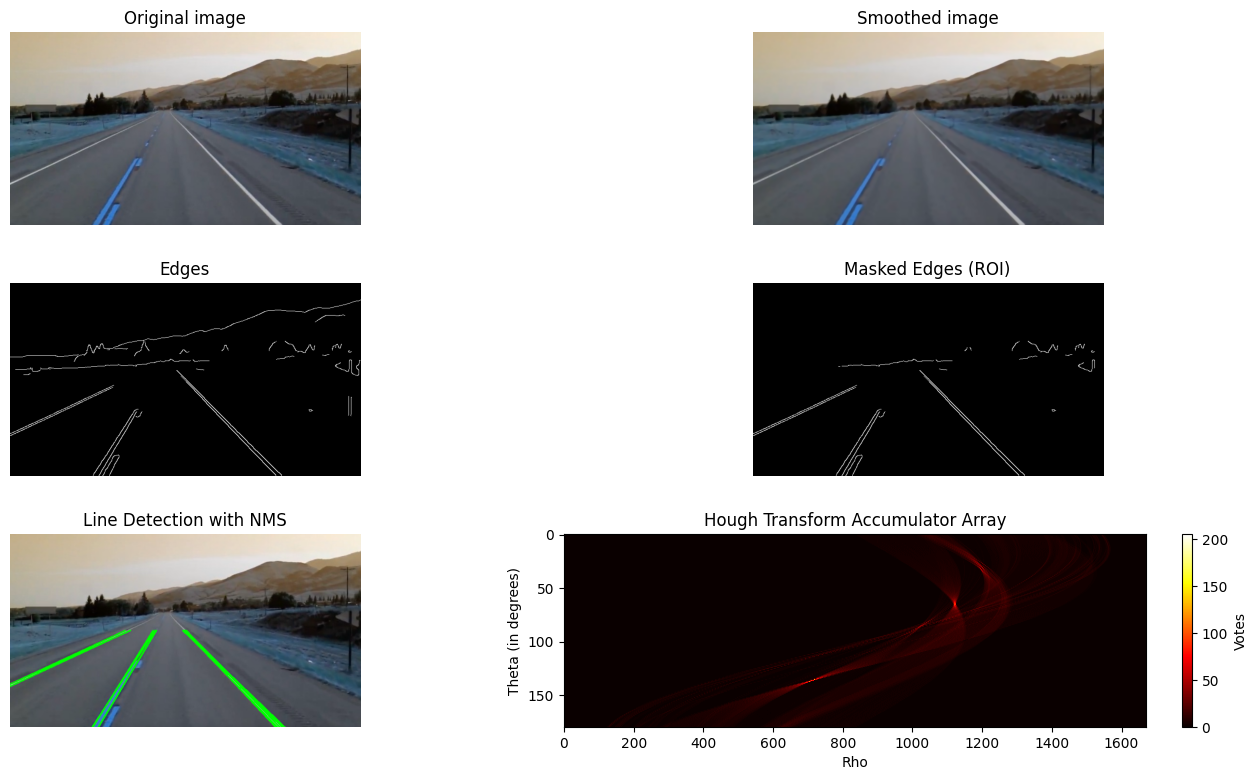

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and process the image
img = cv2.imread(r"C:\Users\nabee\OneDrive\Desktop\WhatsApp Image 2024-11-05 at 02.43.58_6d4d84b2.jpg")
smoothed_img = cv2.medianBlur(img, 5)  # Smoothing
gray_img = cv2.cvtColor(smoothed_img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_img, 100, 200)  # Edge detection

# Masking region of interest
height, width = edges.shape
polygon = np.array([
    [(int(0 * width), height),
     (int(0.9 * width), height),
     (int(1 * width), int(0.23 * height)),
     (int(0 * width), int(0.5 * height))]
])
mask = np.zeros_like(edges)
cv2.fillPoly(mask, [polygon], 255)
masked_edges = cv2.bitwise_and(edges, mask)

# Hough Transform Parameters
rho_max = int(np.hypot(height, width))
accumulator = np.zeros((180, 2 * rho_max), dtype=np.int32)
thetas = np.deg2rad(np.arange(180))

# Custom Hough Transform
for y in range(masked_edges.shape[0]):
    for x in range(masked_edges.shape[1]):
        if masked_edges[y, x]:  # Only process edge points
            for theta_idx, theta in enumerate(thetas):
                rho_val = int(x * np.cos(theta) + y * np.sin(theta) + rho_max)
                accumulator[theta_idx, rho_val] += 1

# Function for finding peaks with non-maximum suppression
def find_peaks(accumulator, threshold, neighborhood_size):
    peaks = []
    for i in range(neighborhood_size // 2, accumulator.shape[0] - neighborhood_size // 2):
        for j in range(neighborhood_size // 2, accumulator.shape[1] - neighborhood_size // 2):
            if accumulator[i, j] > threshold:
                # Extract the local neighborhood
                neighborhood = accumulator[i - neighborhood_size // 2:i + neighborhood_size // 2 + 1,
                                           j - neighborhood_size // 2:j + neighborhood_size // 2 + 1]
                # Apply non-maximum suppression
                if accumulator[i, j] == np.max(neighborhood):
                    peaks.append((i, j))  # Store (theta, rho) indices for detected peaks
    return peaks

# Apply peak detection with NMS on the accumulator array
line_threshold = 100  # Adjust this threshold to control sensitivity
neighborhood_size = 3  # Size for NMS
peaks = find_peaks(accumulator, line_threshold, neighborhood_size)

# Draw lines based on detected peaks
line_image = np.copy(img)
mid_height = height // 2

for theta_idx, rho in peaks:
    theta = thetas[theta_idx]
    rho_val = rho - rho_max
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho_val
    y0 = b * rho_val

    # Define start and end points with limited length
    line_length = 1000
    x1 = int(x0 + line_length * (-b))
    y1 = int(y0 + line_length * (a))
    x2 = int(x0 - line_length * (-b))
    y2 = int(y0 - line_length * (a))
    
    # Clip the line to start from the midpoint downward
    if y1 < mid_height or y2 < mid_height:
        if y2 != y1:  # Avoid division by zero for horizontal lines
            t = (mid_height - y0) / (y2 - y1)
            x_mid = int(x0 + t * (x2 - x1))
            y_mid = mid_height
            if y1 < mid_height:
                x1, y1 = x_mid, y_mid
            if y2 < mid_height:
                x2, y2 = x_mid, y_mid
    
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Visualization
plt.figure(figsize=(15, 15))

# Original Grayscale vs Smoothed Grayscale
plt.subplot(6, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original image")
plt.axis("off")

plt.subplot(6, 2, 2)
plt.imshow(smoothed_img, cmap='gray')
plt.title("Smoothed image")
plt.axis("off")

# Smoothed Grayscale vs Edge Detection Output
plt.subplot(6, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title("Edges")
plt.axis("off")

plt.subplot(6, 2, 4)
plt.imshow(masked_edges, cmap='gray')
plt.title("Masked Edges (ROI)")
plt.axis("off")

plt.subplot(6, 2, 5)
plt.imshow(line_image, cmap='gray')
plt.title("Line Detection with NMS")
plt.axis("off")

# Accumulator Array Visualization
plt.subplot(6, 2, 6)
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.colorbar(label="Votes")
plt.title("Hough Transform Accumulator Array")
plt.xlabel("Rho")
plt.ylabel("Theta (in degrees)")

plt.tight_layout()
plt.show()
